In [1]:
import numpy as np  # 导入NumPy库
import matplotlib.pyplot as plt  # 导入Matplotlib库
from mpl_toolkits.mplot3d import Axes3D

def pairwise_distances(X):
    n_samples = X.shape[0]  # 获取样本数量：即获取数据集 X 的行数
    dist_matrix = np.zeros((n_samples, n_samples))  # 初始化距离矩阵为零矩阵
    for i in range(n_samples):  # 计算第 i 和第 j 个样本之间的欧氏距离
        for j in range(n_samples):
            # 计算欧氏距离
            dist_matrix[i, j] = np.sqrt(np.sum((X[i] - X[j]) ** 2))
    return dist_matrix

# 一个能够为 X 中每个值输出 N x k 矩阵的函数，其中每个值有 k 个最近邻
def nearest_neighbors(X, k):
    knn_matrix = np.zeros((len(X), k), dtype=int)  # 使用 int 类型数组初始化 knn_matrix
    dist_matrix = pairwise_distances(X)  # 重新计算成对距离
    for i in range(len(X)):
        # 对每一行找到 k 个最近邻的索引
        knn_matrix[i] = dist_matrix[i, :].argsort()[1:k + 1].astype(int)  # 将索引数组转换为 int 类型
    return knn_matrix  # 返回最近邻矩阵

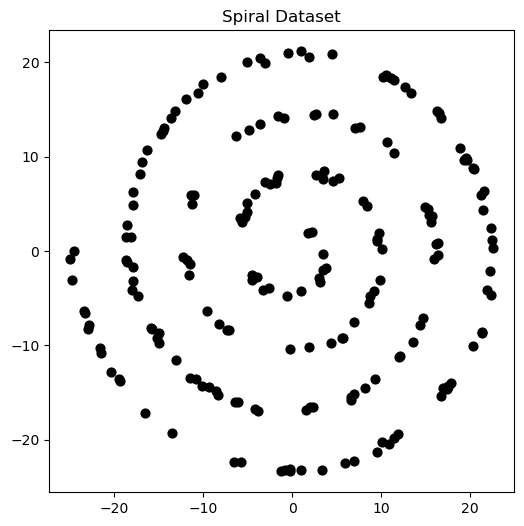

In [2]:
import seaborn as sns  # 导入Seaborn库 

plt.figure(figsize=(6,6))  # 创建一个图表，设置尺寸为6x6
# 在单元格中显示多个输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
np.random.seed(8888)  # 设置随机种子

# 生成螺旋数据集
n = np.sqrt(np.random.rand(200,1)) * 1440 * (2*np.pi)/360
d1x = -np.cos(n)*n + np.random.rand(200,1) * 0.8
d1y = np.sin(n)*n + np.random.rand(200,1) * 0.8

plt.scatter(d1x, d1y, c='black', s=40)  # 绘制散点图
plt.title('Spiral Dataset')  # 设置图表标题
X = np.hstack((d1x,d1y));  # 将数据组合成特征矩阵

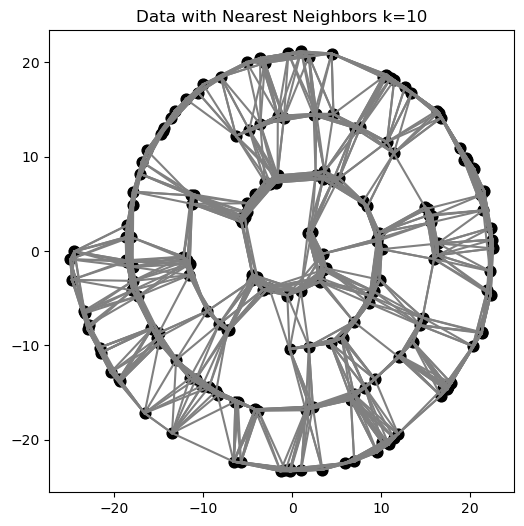

In [3]:
k = 10  # 设置最近邻数量
# 寻找每个数据点的最近邻
X_neighbors = nearest_neighbors(X, k)

# 遍历每个数据点并连接到其最近邻
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], alpha=0.3, c='black', s=50)  # 绘制散点图
for i in range(len(X)):
    neighbors = X_neighbors[i]
    for j in range(len(neighbors)):
        # 绘制每个数据点到其最近邻的连线
        plt.plot(X[[i, neighbors.astype('int')[j]], 0], X[[i, neighbors.astype('int')[j]], 1], c='gray')

plt.title('Data with Nearest Neighbors k=' + str(k))  # 设置图标题
plt.scatter(X[:,0], X[:,1], c='black', s=60)  # 重新绘制散点图，突出数据点
plt.show();  # 显示图形

In [4]:
# Dijkstra 算法实现
def dijkstra_shortest_path(graph, start):
    n = graph.shape[0]  # 获取图的大小
    visited = np.zeros(n, dtype=bool)  # 用于标记节点是否被访问过的数组
    distances = np.full(n, np.inf)  # 到各个节点的距离，初始化为无穷大
    distances[start] = 0  # 设置起始节点的距离为 0

    for _ in range(n):  # 迭代图中的节点数次
        current = -1  # 当前节点
        min_distance = np.inf  # 最小距离

        # 找到当前节点中距离起始节点最近的未访问节点
        for i in range(n):  # 遍历图中的所有节点
            if not visited[i] and distances[i] < min_distance:  # 如果节点未被访问且距离小于最小距离
                current = i  # 更新当前节点
                min_distance = distances[i]  # 更新最小距离

        if current == -1:  # 如果当前节点为 -1，即没有找到符合条件的节点
            break  # 跳出循环

        visited[current] = True  # 将当前节点标记为已访问
        # 更新与当前节点相邻的节点的距离
        for neighbor in range(n):  # 遍历当前节点相邻的节点
            if not visited[neighbor] and graph[current, neighbor] > 0:  # 如果相邻节点未被访问且存在连接
                new_distance = distances[current] + graph[current, neighbor]  # 计算新的距离
                if new_distance < distances[neighbor]:  # 如果新的距离小于原来的距离
                    distances[neighbor] = new_distance  # 更新距离
    return distances  # 返回最短路径距离数组


# MDS 算法实现
def MDS(distances, n_components):
    n = distances.shape[0]  # 获取数据集的大小
    J = np.eye(n) - np.ones((n, n)) / n  # 计算中心化矩阵 J
    B = -0.5 * J.dot(distances ** 2).dot(J)  # 计算矩阵 B
    eigenvalues, eigenvectors = np.linalg.eigh(B)  # 计算特征值和特征向量

    # 对特征值和特征向量进行排序
    indices = np.argsort(eigenvalues)[::-1]  # 获取特征值降序排列的索引
    eigenvalues = eigenvalues[indices]  # 根据索引重新排序特征值
    eigenvectors = eigenvectors[:, indices]  # 根据索引重新排序特征向量

    # 选择前 n_components 个特征值和对应的特征向量
    eigenvalues = eigenvalues[:n_components]  # 选择前 n_components 个特征值
    eigenvectors = eigenvectors[:, :n_components]  # 选择对应的特征向量

    # 计算降维后的结果
    embeddings = eigenvectors.dot(np.diag(np.sqrt(eigenvalues)))  # 计算降维后的嵌入结果
    return embeddings  # 返回嵌入结果


# 执行 Isomap 算法
def isomap(X, n_neighbors, n_components):
    #  1: 通过欧式距离计算成对距离矩阵 dist_matrix
    dist_matrix = pairwise_distances(X)
    #  2: 基于1.构建 k 最近邻图的距离矩阵 knn_matrix
    knn_matrix = nearest_neighbors(X, n_neighbors)
    #  3: 基于1.和2.构建 k 最近邻图的邻接矩阵 adjacency_matrix
    adjacency_matrix = np.zeros((len(X), len(X)))
    for i in range(len(X)):
        for j in knn_matrix[i]:
            adjacency_matrix[i][int(j)] = dist_matrix[i][int(j)]
            adjacency_matrix[int(j)][i] = dist_matrix[int(j)][i]
    #  4: 基于3.使用迪杰斯特拉算法计算最短路径并得到成对的测地距离 shortest_paths
    shortest_paths = np.zeros((len(X), len(X)))
    for i in range(len(X)):
        shortest_paths[i] = dijkstra_shortest_path(adjacency_matrix, i)
    #  5: 应用 MDS 算法获取低维嵌入结果
    embeddings = MDS(shortest_paths, n_components)
    return embeddings

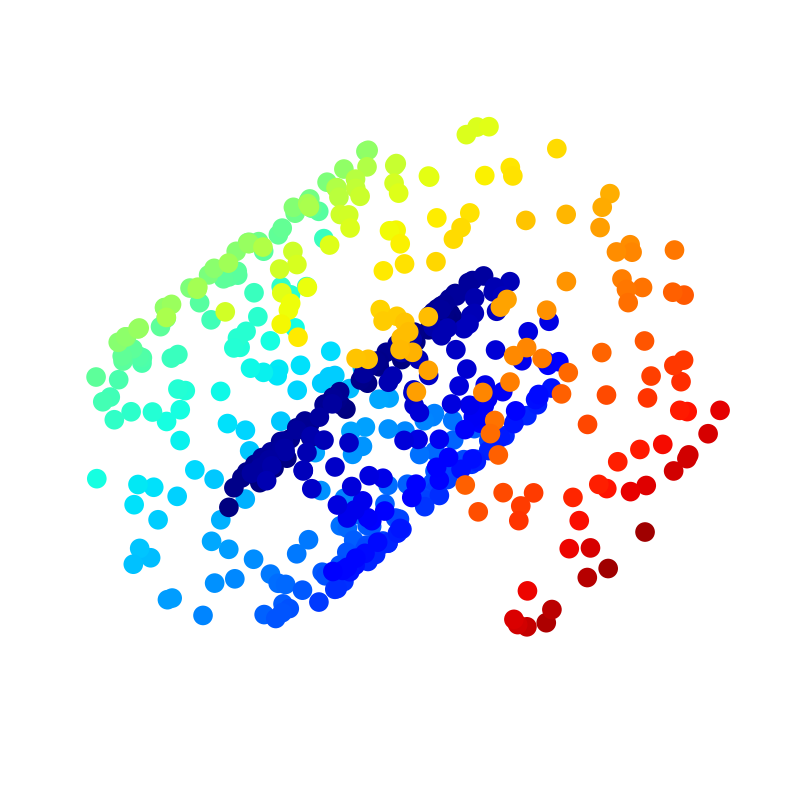

In [5]:
# generate data
n = 500
x = np.random.rand(2,n)

# swiss roll transformation
v = 3*np.pi/2*(.1 + 2*x[0,:])
X  = np.zeros([3,n])
X[1,:] = 20*x[1,:]
X[0,:] = - np.cos(v)*v
X[2,:] = np.sin(v)*v

# plot swiss roll
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X[0,:], X[1,:], X[2,:], c=plt.cm.jet((X[0,:]**2+X[2,:]**2)/100), s=200, lw=0, alpha=1)
ax.set_xlim(np.min(X[0,:]),np.max(X[0,:]))
ax.set_ylim(np.min(X[1,:]),np.max(X[1,:]))
ax.set_zlim(np.min(X[2,:]),np.max(X[2,:]))
ax.axis("off");

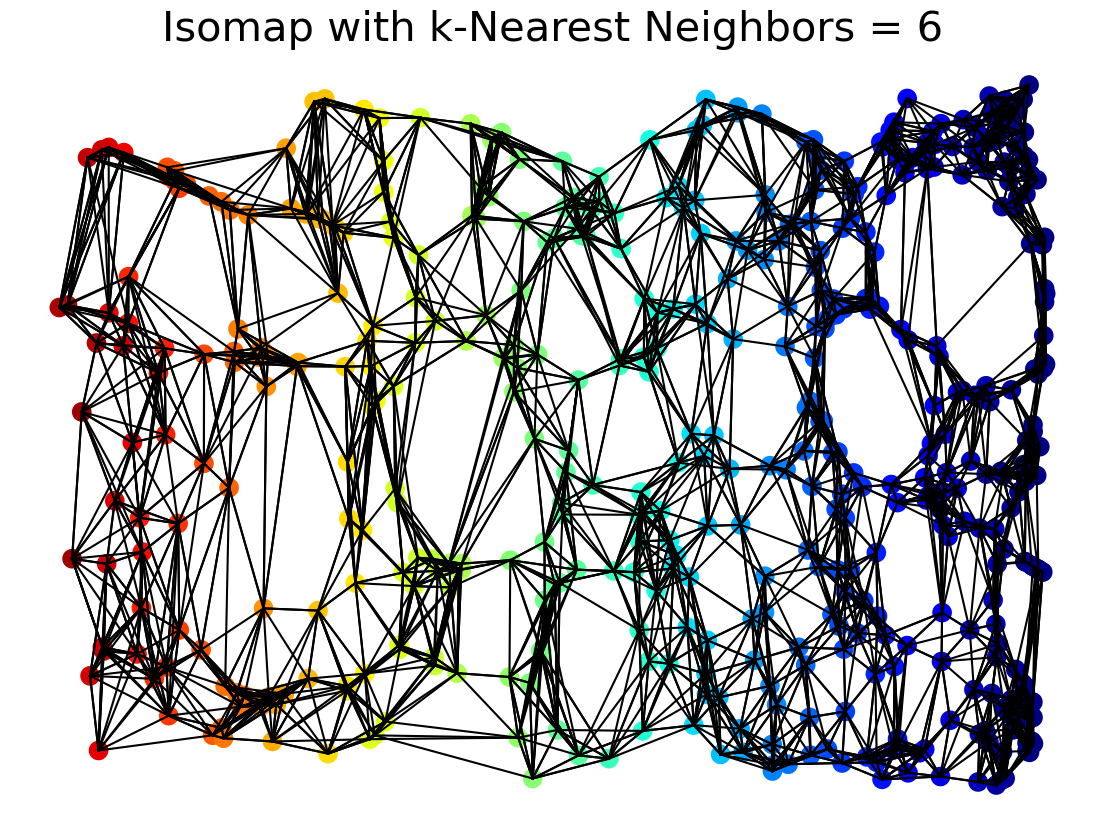

In [6]:
# 将 X 格式化为 (n_samples, n_features)
X = np.transpose(X)
# 设置参数
n_neighbors = 6
n_components = 2
data = X  # 数据

# 执行 Isomap 算法
isomap_embeddings = isomap(data, n_neighbors, n_components)

# 绘制 Isomap 投影图
plt.figure(figsize=(14,10))
plt.scatter(isomap_embeddings[:, 0], isomap_embeddings[:, 1], c=plt.cm.jet((X[:,0]**2+X[:,2]**2)/100), s=200, lw=0, alpha=1)

# 绘制连接原始数据中相同相邻点的线
knn = nearest_neighbors(X, k)  # 使用自定义函数找到每个数据点的最近邻
for i in range(len(X)):
    neighbors = knn[i]
    for j in range(len(neighbors)):
        plt.plot(isomap_embeddings[[i, neighbors.astype('int')[j]], 0], 
                 isomap_embeddings[[i, neighbors.astype('int')[j]], 1], color='black');  
plt.title('Isomap with k-Nearest Neighbors = ' + str(n_neighbors), size=30)
plt.axis("off")
plt.show();

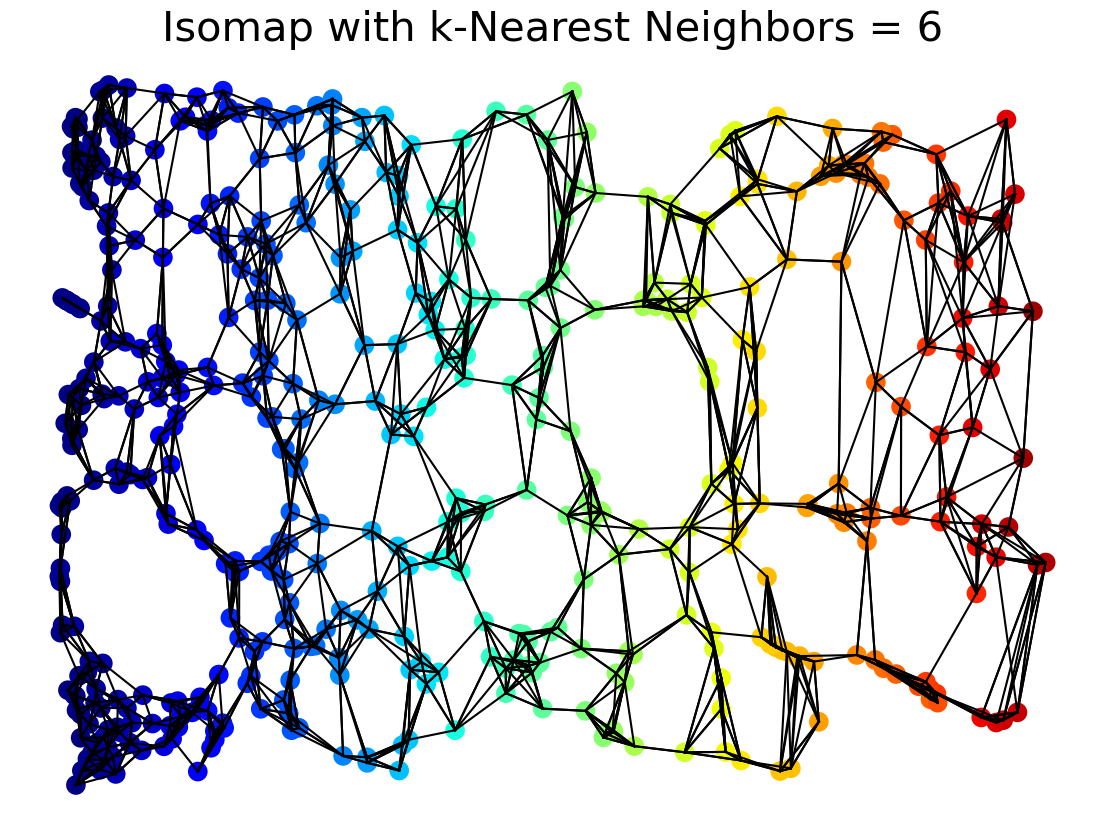

In [8]:
from sklearn.manifold import Isomap
from sklearn.neighbors import NearestNeighbors

# 将 X 格式化为 (n_samples, n_features)
X = np.transpose(X)
data = X
k = 6

# 创建 NearestNeighbors 模型并拟合数据
knn1 = NearestNeighbors(n_neighbors=k, algorithm='auto')
knn1.fit(data)

# 应用 Isomap，设置输出维度为2
model = Isomap(n_components=2, n_neighbors=k)
proj = model.fit_transform(data)

# plot the isomap projection
plt.figure(figsize=(14,10))
plt.scatter(proj[:, 0], proj[:, 1], c=plt.cm.jet((X[:,0]**2+X[:,2]**2)/100), s=200, lw=0, alpha=1)

# plot lines connecting the same neighboring points from our original data
indices = knn1.kneighbors(return_distance=False)
for i in range(len(data)):
    neighbors = indices[i]
    for j in range(len(neighbors)):
        plt.plot(proj[[i, neighbors[j]], 0], proj[[i, neighbors[j]], 1], color='black')

plt.title('Isomap with k-Nearest Neighbors = ' + str(k), size=30)
plt.axis("off")
plt.show();
